<a href="https://colab.research.google.com/github/moralesluis26/Deteccion-de-defectos-superficiales-en-aceros-haciendo-uso-de-Deep-Learning/blob/main/Final__Clasificaci%C3%B3n_de_defectos_en_superficies_met%C3%A1licas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook Clasificacón de defectos en superficies metálicas
Por: Luis David Morales

##1. Carga y preparación de datos.

Para poder correr el Notebook se requiere subir el API que puede descargarse desde el perfil de Kaggle. Se recomienda subir un API actualizado, debido a que los más antiguos presentaran problemas de validación.

In [1]:
from google.colab import files
files.upload()  # Esto te pedirá que subas tu archivo kaggle.json



Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"luisdavidmorales","key":"e51f7e7f66bc0bd231d5e4e380790aae"}'}

In [2]:
import os
import numpy as np
# Creación del directorio .kaggle en el entorno

os.makedirs("/root/.kaggle", exist_ok=True)

# Mover el archivo kaggle.json al directorio correcto
!mv kaggle.json /root/.kaggle/


In [3]:
!pip install kaggle


In [4]:
!kaggle competitions download -c severstal-steel-defect-detection # Descarga del dataset disponible en Kaggle.


100% 1.56G/1.57G [00:22<00:00, 69.2MB/s]
100% 1.57G/1.57G [00:23<00:00, 73.2MB/s]


In [5]:
import zipfile

# Con este código se descomprime el archivo ZIP descargado de Kaggle.

with zipfile.ZipFile("severstal-steel-defect-detection.zip", "r") as zip_ref:
    zip_ref.extractall("severstal_steel_defect_data")


A continuación se lee el archivo train.csv usando Pandas.
Al imprimir las primeras filas se observa que el arcivo csv posee 3 columnas, la primera correspondiente al nombre de las imágenes, la segunda corresponde al tipo de defecto en la superficie del metal, siendo este un valor de 1 a 4 para clasificar según el tipo, y la terecera es una información adicional utilizada en la competencia original para enviar las respuestas de una forma más efectiva, sin embargo no se utilizará en este Notebook.

In [6]:
import pandas as pd
# Cargar el archivo train.csv
cantidad_datos= 100 # En esta parte se selecciona la cantidad de datos con la que se quiere trabajar en los distintos modelos.
train_csv_path = "severstal_steel_defect_data/train.csv"
train_data_1 = pd.read_csv(train_csv_path)
train_data = train_data_1.iloc[:cantidad_datos]
# Ver las primeras filas
print(train_data.head())
# Obtener el número de filas
num_filas = train_data.shape[0]
print(f"El archivo contiene {num_filas} filas.")


         ImageId  ClassId                                      EncodedPixels
0  0002cc93b.jpg        1  29102 12 29346 24 29602 24 29858 24 30114 24 3...
1  0007a71bf.jpg        3  18661 28 18863 82 19091 110 19347 110 19603 11...
2  000a4bcdd.jpg        1  37607 3 37858 8 38108 14 38359 20 38610 25 388...
3  000f6bf48.jpg        4  131973 1 132228 4 132483 6 132738 8 132993 11 ...
4  0014fce06.jpg        3  229501 11 229741 33 229981 55 230221 77 230468...
El archivo contiene 100 filas.


En esta parte se dividen las imagenes para entrenamiento y validación, donde el 20% corresponde a la cantidad de imagenes dispuesta para la validación.

In [7]:
from sklearn.model_selection import train_test_split

image_names = train_data.iloc[:, 0]
labels = train_data.iloc[:, 1]
labels_mod=labels-1 # Debido a que la clasificación de defectos en el dataset se hace con numeros del 1 al 4, se resta el valor de 1 para trabajar con números de 0 a 3 y así evitar inconvenientes.

train_images, val_images, train_labels, val_labels = train_test_split(image_names, labels_mod, test_size=0.2, random_state=42) # División de datos



Visualización de una de las imagenes correspodientes al dataset de entrenamiento.

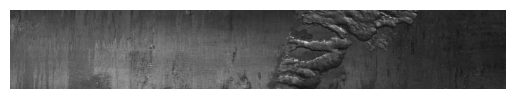

In [8]:

from PIL import Image
import matplotlib.pyplot as plt

train_images_dir = "severstal_steel_defect_data/train_images"
test_images_dir = "severstal_steel_defect_data/test_images"

image_path = os.path.join(train_images_dir, image_names[10])  # Selección de una imágen, la #10 en train_images

# Abrir la imagen con PIL
image = Image.open(image_path)

# Mostrar la imagen
plt.imshow(image)
plt.axis('off')  # Desactivar los ejes
plt.show()


##2. Preparación de los datasets de entrenamiento y validación para los modelos de clasificación.
Para esto se cargan, se decodifican, se dimensionan y se normaliza el valor de los pixeles.

In [9]:
import tensorflow as tf

def load_and_preprocess_image(image_name, label, image_dir):
    image_name = tf.strings.join([image_dir, "/", image_name])
    image = tf.io.read_file(image_name)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])  # Redimension de imagen
    image = image / 255.0  # Normalizar entre 0 y 1 del valor de los pixeles
    return image, label

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.map(lambda x, y: load_and_preprocess_image(x, y, train_images_dir))
train_dataset = train_dataset.batch(32).shuffle(100)

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_dataset = val_dataset.map(lambda x, y: load_and_preprocess_image(x, y, train_images_dir))
val_dataset = val_dataset.batch(32)

##3. Modelos.

###Modelo personalizado:

El primero modelo se ha construido desde cero, basado de modelos preentrenados.
Este modelo posee tres capas convolucionales de 32, 64 y 128 filtros con ventanas de 3x3.
Después de cada capa se aplica el pooling para reducir las dimensiones espaciales de las caracteríticas y hacer la red más eficiente.
Posteriormente se aplica el Flatten para obtener vectores unidimensionales y así alimentar las capas posteriores.
Las capas densas se disponen de la siguiente forma:
- Una capa completamente conectada con 128 unidades y activación ReLU.
- Una capa final con 4 neuronas y activación softmax para realizar la clasificación en 4 clases.

Por último, el 'sparse_categorical_crossentropy' se selecciona ya que es adecuado para la clasificación multiclase cuando las etiquetas (clasificador de defectos para el caso particular) son enteros.

In [10]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(4, activation='softmax')  # 4 clases de defectos
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 6s/step - accuracy: 0.4083 - loss: 1.7883 - val_accuracy: 0.1000 - val_loss: 1.3219
Epoch 2/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step - accuracy: 0.4260 - loss: 1.1077 - val_accuracy: 0.7000 - val_loss: 0.8982
Epoch 3/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - accuracy: 0.6180 - loss: 1.0598 - val_accuracy: 0.7000 - val_loss: 0.8727


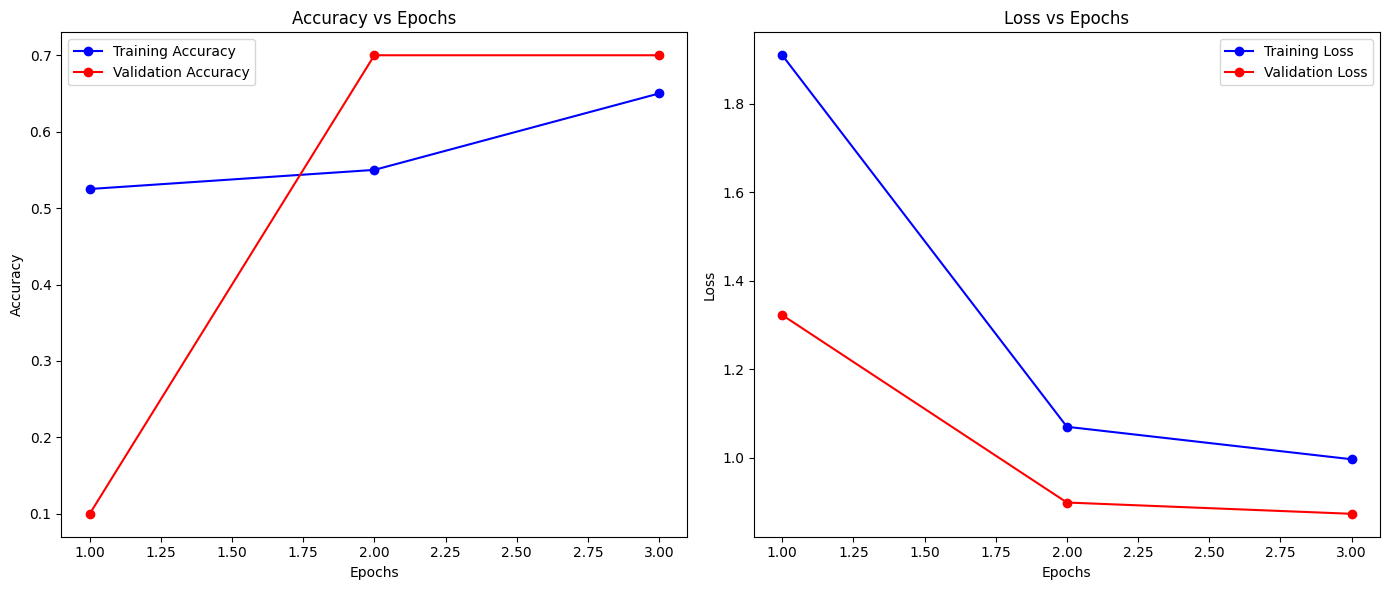

In [11]:
history = model.fit(train_dataset,epochs=3,validation_data=val_dataset)

# Grafica de  la evolución de las métricas
def plot_training_history(history):
    # Extraer datos del historial
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Creación de subgráficos para separar accuracy y loss
    plt.figure(figsize=(14, 6))

    # Gráfico de accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Gráfico de loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
plot_training_history(history)

In [12]:
test_loss, test_accuracy = model.evaluate(val_dataset)
print(f"Accuracy en el conjunto de prueba: {test_accuracy:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7000 - loss: 0.8727
Accuracy en el conjunto de prueba: 0.70


Definición de la métrica Dice

In [13]:
import tensorflow as tf

# Función para calcular el coeficiente Dice
def dice_coefficient(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    # Convertir y_true a int64 para one_hot
    y_true = tf.cast(y_true, tf.int64)
    # Convertir y_true a one-hot encoding para que coincida con la forma de y_pred
    y_true = tf.one_hot(y_true, depth=4) # depth debe ser igual al número de clases
    y_pred = tf.round(y_pred)  # Redondear para binarizar las predicciones

    intersection = tf.reduce_sum(y_true * y_pred, axis=[-1])

    union = tf.reduce_sum(y_true, axis=[-1]) + tf.reduce_sum(y_pred, axis=[-1])

    dice = (2.0 * intersection + tf.keras.backend.epsilon()) / (union + tf.keras.backend.epsilon())

    return dice

Uso de la métrica Dice

In [14]:
def evaluate_dice(model, dataset):
    dice_scores = []
    for images, labels in dataset:
        predictions = model.predict(images)
        batch_dice = dice_coefficient(labels, predictions)
        dice_scores.append(batch_dice.numpy())
    return tf.reduce_mean(dice_scores).numpy()

# Llamar la función con el dataset de validación
dice_val = evaluate_dice(model, val_dataset)
print(f"Coeficiente Dice en Validación: {dice_val:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 833ms/step
Coeficiente Dice en Validación: 0.7000


Definición de función para extraer el valor real de la clase de defectos.

In [15]:


# Función para obtener la clase real basada en el nombre de la imagen
def get_real_class(image_name):
    # Buscar la fila correspondiente al nombre de la imagen
    row = train_data.loc[train_data['ImageId'] == image_name]

    if not row.empty:
        # Extraer la clase de la columna 'Class'
        real_class = row['ClassId'].values[0]
        return real_class
    else:
        # Si no se encuentra la imagen en el CSV
        return None

Matriz de confusión para tener un dato visual de la acantidad de aciertos en cada clase.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 902ms/step


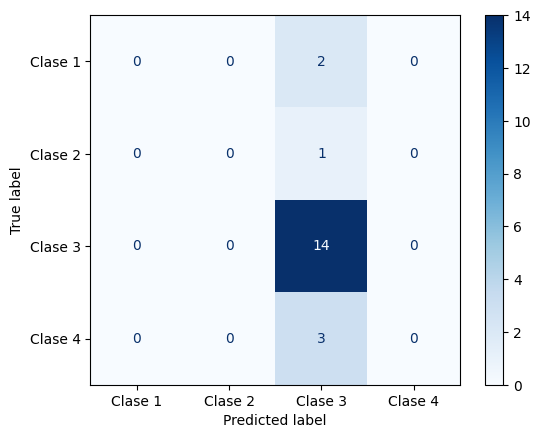

In [16]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Obtener las predicciones del modelo
y_pred = np.argmax(model.predict(val_dataset), axis=1)
y_true = np.concatenate([y for x, y in val_dataset], axis=0)

# Calcular la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Visualizar la matriz
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Clase 1', 'Clase 2', 'Clase 3', 'Clase 4'])
disp.plot(cmap='Blues')


Predicción de una sola imagen usando el modelo personalizado ya entrenado.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


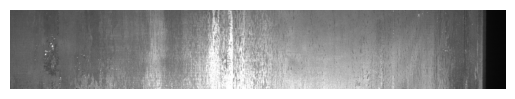

Clase predicha de la imagen '031f334ec.jpg': 3
Clase real de '031f334ec.jpg': 3


In [17]:
# Predicción en una sola imagen
def predict_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = image / 255.0
    image = tf.expand_dims(image, axis=0)  # Añadir dimensión batch
    prediction = model.predict(image)
    return tf.argmax(prediction, axis=1).numpy()[0]


#Imágen individual
image_name = image_names[90]

# Seleccionar una imagen específica (por ejemplo, la primera de train_images)
image_path = os.path.join(train_images_dir, image_name)  # La imagen #10 en train_images
predicted_class = predict_image(image_path)+1 # Se suma el uno que se había restado antes para el procesamiento de datos.
image = Image.open(image_path)
# Mostrar la imagen
plt.imshow(image)
plt.axis('off')  # Desactivar los ejes
plt.show()

print(f"Clase predicha de la imagen '{image_name}': {predicted_class}")

# Cálculo de clase real

real_class = get_real_class(image_name)
if real_class is not None:
    print(f"Clase real de '{image_name}': {real_class}")
else:
    print(f"'{image_name}' no se encuentra en el archivo CSV.")


###En esta sección se monta el modelo preentrenado VGG16 para ver su capacidad de predecir los defectos en las imágnes utilizando las mismas nétricas del modelo personalizado.

Inicialmente se impide el entrenamiento de los pesos del modelo VGG16 para comparar los resultados con respecto al mismo modelo pero permitiendo la actualización de los pesos.

In [18]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers

# Cargar el modelo base VGG16 preentrenado
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar las capas del modelo base para no entrenarlas al principio
vgg16_base.trainable = False


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [19]:
# Crear el modelo completo
model = models.Sequential([
    vgg16_base,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')  # 4 debido a que es el núemro de clases
])

# Compilar el modelo
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()  # Para verificar la arquitectura


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,138,500 (80.64 MB)

 Trainable params: 6,423,812 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 62s 19s/step - accuracy: 0.3672 - loss: 3.8488 - val_accuracy: 0.2000 - val_loss: 2.7416
Epoch 2/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 59s 20s/step - accuracy: 0.4776 - loss: 2.3727 - val_accuracy: 0.7000 - val_loss: 1.5653
Epoch 3/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 89s 24s/step - accuracy: 0.5273 - loss: 2.1962 - val_accuracy: 0.7000 - val_loss: 1.1245


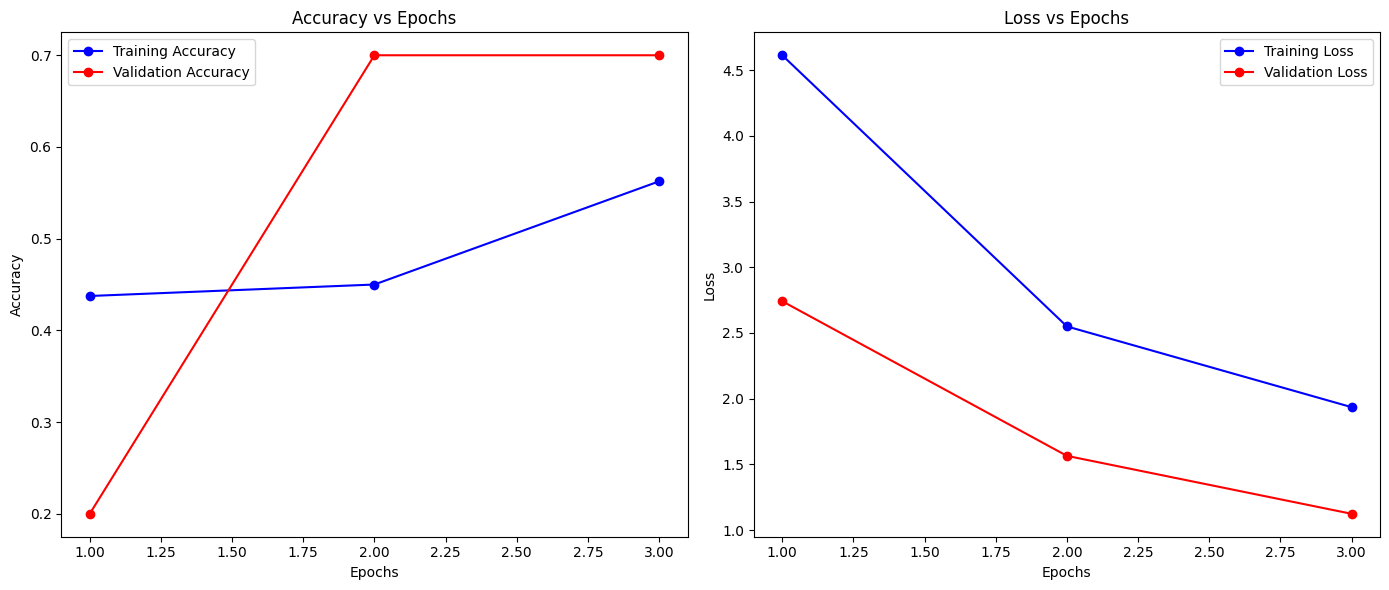

In [20]:
history = model.fit(train_dataset, validation_data=val_dataset,epochs=3)
def plot_training_history(history):
    # Grafica de  la evolución de las métricas
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Crear subgráficos para separar accuracy y loss
    plt.figure(figsize=(14, 6))

    # Gráfico de accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Gráfico de loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Llamar a la función con el historial del entrenamiento
plot_training_history(history)

En esta parte se activa la actualización de pesos en el modelo preentrenado.

In [21]:
# Descongelar las capas superiores del modelo base
vgg16_base.trainable = True

# Compilar nuevamente el modelo con un optimizador de menor tasa de aprendizaje
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Reentrenar el modelo
history_fine_tuning = model.fit(train_dataset,validation_data=val_dataset, epochs=3)


Epoch 1/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 197s 61s/step - accuracy: 0.6708 - loss: 1.4978 - val_accuracy: 0.7000 - val_loss: 1.0418
Epoch 2/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 186s 71s/step - accuracy: 0.6729 - loss: 1.0395 - val_accuracy: 0.7000 - val_loss: 1.0786
Epoch 3/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 203s 54s/step - accuracy: 0.7063 - loss: 1.2202 - val_accuracy: 0.7000 - val_loss: 1.0622


In [22]:
# Evaluar el modelo
test_loss, test_accuracy = model.evaluate(val_dataset)
print(f"Accuracy en el conjunto de prueba: {test_accuracy:.2f}")

# Guardar el modelo
model.save('vgg16_steel_defect_model.h5')


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.7000 - loss: 1.0622


Accuracy en el conjunto de prueba: 0.70


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


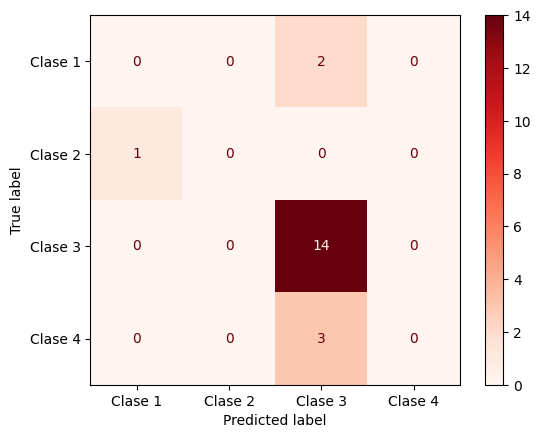

In [23]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Obtener las predicciones del modelo
y_pred = np.argmax(model.predict(val_dataset), axis=1)
y_true = np.concatenate([y for x, y in val_dataset], axis=0)

# Calcular la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Visualizar la matriz
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Clase 1', 'Clase 2', 'Clase 3', 'Clase 4'])
disp.plot(cmap='Reds')

In [24]:

# Función con el dataset de validación
dice_val = evaluate_dice(model, val_dataset)
print(f"Coeficiente Dice en Validación: {dice_val:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
Coeficiente Dice en Validación: 0.7000


In [25]:
print('Nombre de la imágen:', image_names[10])

Nombre de la imágen: 0030401a5.jpg


Predicción individual de las imágenes, utilizando el modelo VGG16 con los pesos actualizados.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step


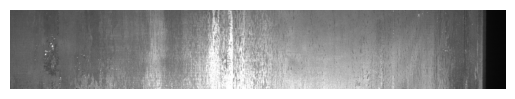

Clase predicha de la imagen '031f334ec.jpg': 3
Clase real de '031f334ec.jpg': 3


In [26]:

#Imágen individual
image_name = image_names[90]

# Seleccionar una imagen específica (por ejemplo, la primera de train_images)
image_path = os.path.join(train_images_dir, image_name)  # La imagen #10 en train_images
predicted_class = predict_image(image_path)+1 # Se suma el uno que se había restado antes para el procesamiento de datos.
image = Image.open(image_path)
# Mostrar la imagen
plt.imshow(image)
plt.axis('off')  # Desactivar los ejes
plt.show()

print(f"Clase predicha de la imagen '{image_name}': {predicted_class}")

# Cálculo de clase real

real_class = get_real_class(image_name)
if real_class is not None:
    print(f"Clase real de '{image_name}': {real_class}")
else:
    print(f"'{image_name}' no se encuentra en el archivo CSV.")


